# ITU-ML5G-PS-005-KDDI

In [1]:
import gc
import numpy as np
import pandas as pd
from tools.preprocessing import Processor
from tools.generator import ReccurentTrainingGenerator, ReccurentTestGenerator

2022-11-22 04:52:12.624815: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-22 04:52:12.627715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 04:52:12.627725: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load data

In [2]:
train_0 = pd.read_csv('data/ML5G-PS-005_train_0.csv', index_col=0, header=0)
train_1 = pd.read_csv('data/ML5G-PS-005_train_1.csv', index_col=0, header=0)
train_2 = pd.read_csv('data/ML5G-PS-005_train_2.csv', index_col=0, header=0)
train_3 = pd.read_csv('data/ML5G-PS-005_train_3.csv', index_col=0, header=0)
train_4 = pd.read_csv('data/ML5G-PS-005_train_4.csv', index_col=0, header=0)
train_5 = pd.read_csv('data/ML5G-PS-005_train_5.csv', index_col=0, header=0)
train_data = pd.concat([train_0, train_1, train_2, train_3, train_4, train_5])
del train_0, train_1, train_2, train_3, train_4, train_5

test_0 = pd.read_csv('data/ML5G-PS-005_test_0.csv', index_col=0, header=0)
test_1 = pd.read_csv('data/ML5G-PS-005_test_1.csv', index_col=0, header=0)
test_2 = pd.read_csv('data/ML5G-PS-005_test_2.csv', index_col=0, header=0)
test_data = pd.concat([test_0, test_1, test_2])
del test_0, test_1, test_2
gc.collect()

0

# Preprocess

In [3]:
preprocessor = Processor(train_data, test_data)

In [4]:
X, Y, test_X, test_Y = preprocessor.get_scaled_data()
test_labels = preprocessor.test_label.values

# Train

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [6]:
timesteps = 15
delay = 45
batch_size = 64
input_dim = X.shape[-1]

In [7]:
input = Input(shape=(timesteps, input_dim))
lstm = LSTM(256, input_shape=(timesteps, input_dim), return_sequences=True)(input)
lstm = LSTM(256)(lstm)
dropout = Dropout(0.5)(lstm)
dense = Dense(1)(dropout)
model = Model(inputs=input, outputs=dense)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

2022-11-22 04:52:30.346540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 04:52:30.346560: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 04:52:30.346574: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hakiitakeru-XPS-13-9305): /proc/driver/nvidia/version does not exist
2022-11-22 04:52:30.346818: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 3325)]        0         
                                                                 
 lstm (LSTM)                 (None, 15, 256)           3667968   
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 4,193,537
Trainable params: 4,193,537
Non-trainable params: 0
_________________________________________________________________


In [8]:
train_X = X[:500*70]
train_Y = Y[:500*70]
val_X = X[500*70:]
val_Y = Y[500*70:]

In [9]:
train_generator = ReccurentTrainingGenerator(train_X, train_Y, batch_size, timesteps, delay)
val_generator = ReccurentTrainingGenerator(val_X, val_Y, batch_size, timesteps, delay)

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [88]:
history = model.fit(x=train_generator, epochs=250, verbose=1, callbacks=callback, validation_data=val_generator)

Epoch 1/250
79/79 [==============================] - 7s 93ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 2/250
79/79 [==============================] - 7s 84ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 3/250
79/79 [==============================] - 7s 85ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 4/250
79/79 [==============================] - 7s 89ms/step - loss: 0.0029 - val_loss: 0.0022


# Evaluation

In [108]:
from tools.metrics import Evaluation
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn import metrics

rcParams['figure.figsize'] = 15, 6

In [90]:
test_generator = ReccurentTestGenerator(test_X, batch_size, timesteps, delay)

In [91]:
pred = model.predict(test_generator)
pred = pred.reshape(300, -1)

47/47 [==============================] - 2s 35ms/step


In [103]:
test_Y = test_Y.reshape(300, -1)

In [104]:
evaluation = Evaluation(pred, test_Y, test_labels, timesteps, delay)

In [105]:
evaluation.MSE()

nan

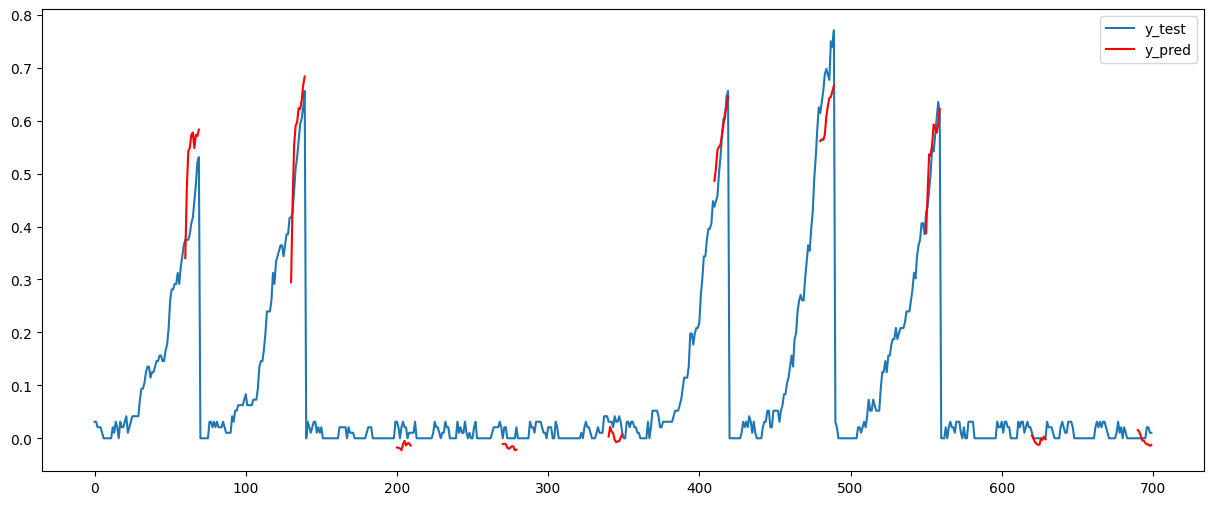

In [111]:
test_vis = test_Y[-20:-10]
pred_vis = pred[-20:-10]
x = np.arange(len(test_vis.flatten()))
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(x, test_vis.flatten(), label='y_test')
for i in range(len(pred_vis)):
    if i==0:
        ax.plot(x[i*70+timesteps+delay:(i+1)*70], pred_vis[i], label='y_pred', c='r')
    else:
        ax.plot(x[i*70+timesteps+delay:(i+1)*70], pred_vis[i], c='r')
ax.legend()
plt.show()

In [19]:
pred.flatten()

array([0.03205338, 0.02415584, 0.02979235, ..., 0.03985957, 0.03821138,
       0.04191187], dtype=float32)

In [28]:
pred_fla = pred.flatten()
test_fla = test_Y[:,timesteps+delay:].flatten()
sum((pred_fla - test_fla)**2)/len(pred_fla)

nan

In [40]:
pred_fla.shape

(3000,)

In [41]:
test_fla.shape

(3000,)

In [43]:
np.isnan(pred_fla).any()

True

In [48]:
np.isnan(pred).any()

True

In [46]:
pred.shape

(300, 10)

In [96]:
np.isnan(pred)[-42,:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [102]:
test_X[-43*70:-42*70]

,amf.amf.app.cadvisor.container_cpu_cfs_periods,amf.amf.app.cadvisor.container_cpu_cfs_throttled_periods,amf.amf.app.cadvisor.container_cpu_cfs_throttled_seconds,amf.amf.app.cadvisor.container_cpu_system_seconds,amf.amf.app.cadvisor.container_cpu_usage_seconds,amf.amf.app.cadvisor.container_cpu_user_seconds,amf.amf.app.cadvisor.container_last_seen,amf.amf.app.cadvisor.container_memory_cache,amf.amf.app.cadvisor.container_memory_failcnt,amf.amf.app.cadvisor.container_memory_failures,...,upf.upf3.infra.tcpstates._::ffff:10.244.0.1_LAST_ACK_CLOSE.usec.avg,upf.upf3.infra.tcpstates._::ffff:10.244.0.1_LAST_ACK_CLOSE.usec.max,upf.upf3.infra.tcpstates._::ffff:10.244.0.1_LAST_ACK_CLOSE.usec.med,upf.upf3.infra.tcpstates._::ffff:10.244.0.1_LAST_ACK_CLOSE.usec.min,upf.upf3.infra.tcpstates._::ffff:10.244.0.1_SYN_RECV_ESTABLISHED.count,upf.upf3.infra.tcpstates._::ffff:10.244.0.1_SYN_RECV_ESTABLISHED.usec.avg,upf.upf3.infra.tcpstates._::ffff:10.244.0.1_SYN_RECV_ESTABLISHED.usec.max,upf.upf3.infra.tcpstates._::ffff:10.244.0.1_SYN_RECV_ESTABLISHED.usec.med,upf.upf3.infra.tcpstates._::ffff:10.244.0.1_SYN_RECV_ESTABLISHED.usec.min,upf.upf3.infra.tcptracer._192.168.13.70_connect.count
17990,0.804518,0.0,0.0,0.629498,0.020208,0.514089,1.000633,0.990370,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17991,0.832690,0.0,0.0,0.643079,0.000000,0.576497,1.000633,0.990388,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17992,0.800481,0.0,0.0,0.534251,0.000000,0.583703,1.000633,0.990419,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17993,0.766791,0.0,0.0,0.607140,0.000000,0.655716,1.000633,0.990432,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17994,0.816125,0.0,0.0,0.598528,0.029536,0.523144,1.000633,0.990481,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18055,0.816479,0.0,0.0,0.592344,0.018100,0.626298,1.000633,0.992423,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18056,0.862403,0.0,0.0,0.714511,0.054241,0.637530,1.000633,0.992459,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18057,0.822490,0.0,0.0,0.620430,0.052426,0.602542,1.000633,0.992481,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18058,0.713523,0.0,0.0,0.510529,0.034861,0.633535,1.000633,0.992521,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
test_labels[-42*70:]

array(['normal', 'normal', 'normal', ..., 'normal', 'normal', 'normal'],
      dtype=object)